In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sn


In [1]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import common_texts, get_tmpfile
import pickle

In [4]:
con = sqlite3.connect('/mydata/final.sqlite')

In [5]:
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con)

In [6]:
final = final.sample(n = 100000)
final.shape

(100000, 12)

In [7]:
l = final['Score']
final = final.drop("Score", axis = 1)

Training Word2Vec model using Text Corpus

In [8]:
list_clean_text = []
for sent in final['CleanedText'].values:
    list_clean_text.append(sent.split())

In [8]:
print(list_clean_text[1])

['tri', 'least', 'differ', 'gluten', 'free', 'flour', 'blend', 'wonder', 'mix', 'contain', 'dairi', 'tree', 'nut', 'concern', 'stop', 'shop', 'buy', 'mix', 'perfect', 'springboard', 'actual', 'edibl', 'bake', 'good', 'well', 'best', 'pancak', 'waffl', 'around']


In [9]:
# Considering Words with minimum occurence of 5 times
w2v_model = Word2Vec(list_clean_text, min_count = 5, size = 50, workers = 2 )

In [11]:
path = get_tmpfile("word2vec.model")
w2v_model.save("word2vec.model")

In [9]:
w2v_model = Word2Vec.load("word2vec.model")

In [10]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words occuring more than 5 times", len(w2v_words))
print("sample words", w2v_words[0:50])

number of words occuring more than 5 times 12665
sample words ['cracker', 'point', 'plus', 'weight', 'watcher', 'food', 'plan', 'win', 'addit', 'tast', 'good', 'tri', 'least', 'differ', 'gluten', 'free', 'flour', 'blend', 'wonder', 'mix', 'contain', 'dairi', 'tree', 'nut', 'concern', 'stop', 'shop', 'buy', 'perfect', 'actual', 'edibl', 'bake', 'well', 'best', 'pancak', 'waffl', 'around', 'love', 'coffe', 'transact', 'fast', 'easi', 'thank', 'much', 'taffi', 'think', 'better', 'regular', 'care', 'eat']


In [13]:
w2v_model.wv.most_similar('like')

[('appeal', 0.7363886833190918),
 ('okay', 0.7136315703392029),
 ('prefer', 0.666817307472229),
 ('dislik', 0.6527740955352783),
 ('weird', 0.6502004265785217),
 ('think', 0.6072103381156921),
 ('good', 0.6032634973526001),
 ('gross', 0.6017309427261353),
 ('normal', 0.5883471369743347),
 ('matter', 0.5866037011146545)]

In [14]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_clean_text: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100000
50


In [15]:
sent_vectors_final = np.asarray(sent_vectors)

In [16]:
print(sent_vectors_final.shape)
l.shape

(100000, 50)


(100000,)

In [17]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(sent_vectors_final)
standardized_data.shape

(100000, 50)

In [18]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state = 0, perplexity = 30)
tsne_data = model.fit_transform(standardized_data)

In [19]:
tsne_data = np.vstack((tsne_data.T, l)).T

In [20]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

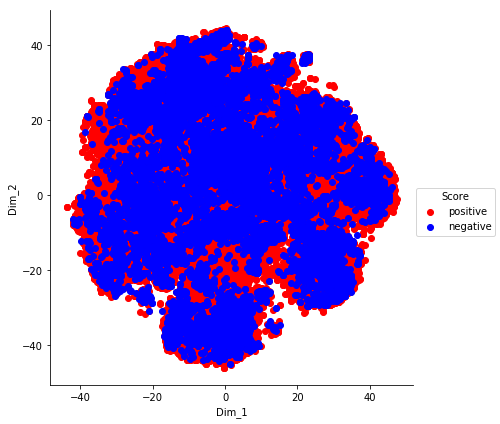

In [21]:
d = dict(color=["r", "b"])
sn.FacetGrid(tsne_df,hue = "Score", hue_kws=d,size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [22]:
model = TSNE(n_components=2, random_state = 0, perplexity = 20, n_iter = 5000)
tsne_data = model.fit_transform(standardized_data)

In [23]:
tsne_data = np.vstack((tsne_data.T, l)).T

In [24]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

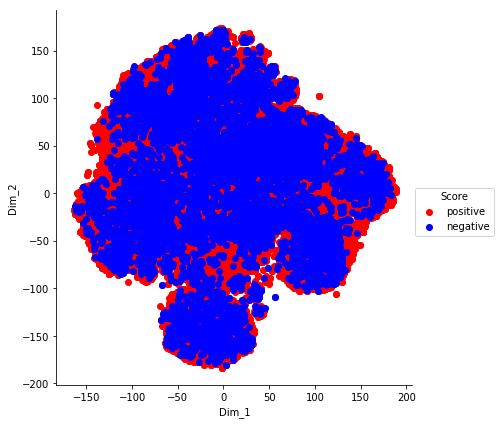

In [25]:
sn.FacetGrid(tsne_df,hue = "Score", hue_kws=d,size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()